In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
%matplotlib inline

In [84]:
imdb_akas_df = pd.read_csv('../data/zippedData/imdb.title.akas.csv.gz')
imdb_ratings_df = pd.read_csv('../data/zippedData/imdb.title.ratings.csv.gz')
imdb_principals_df = pd.read_csv('../data/zippedData/imdb.title.principals.csv.gz')
imdb_name_df = pd.read_csv('../data/zippedData/imdb.name.basics.csv.gz')
movie_gross_df = pd.read_csv('../data/zippedData/bom.movie_gross.csv.gz')

<br>

Finding the top 20 directos by worldwide gross:
- Begin with a DatFrame of all movie titles from the US region and drop the extra rows for movies listed more than once. These are from the alternate titles csv. 
- Then add the ratings for each of those movies by joining with the Imdb ratings csv and condense the DataFrame to only the movies unique id, name and average rating.  

In [85]:
titles = imdb_akas_df[imdb_akas_df['region'] == 'US'].drop_duplicates(subset=['title_id'])
add_ratings = titles.join(imdb_ratings_df.set_index('tconst'), on='title_id')
add_ratings = add_ratings[['title_id', 'title', 'averagerating',]]

<br>

Add Directors, their name and the "worldwide gross" for each movie:
- Build another DataFrame from the IMDb priciples csv containing only those in the director category, then add that DataFrame to the movies DataFrame using each movies unique id. 
- Then use each directors unique id to add on their name contained in the IMDb name csv.
- Add each movies domestic and foreign gross contaied in the movie gross csv from Box Office Mojo by IMDb Pro
- Create a worldwide gross column by adding domestic gross with foreign gross

In [86]:
directors = imdb_principals_df[imdb_principals_df['category'] == 'director']
add_director = add_ratings.join(directors.set_index('tconst'), on='title_id')
add_dir_name = add_director.join(imdb_name_df.set_index('nconst'), on='nconst')
add_gross = add_dir_name.join(movie_gross_df.set_index('title'), on='title')

add_gross['foreign_gross'] = add_gross['foreign_gross'].str.replace(',', '').apply(lambda x: float(x))
add_gross['worldwide_gross'] = add_gross['domestic_gross'] + add_gross['foreign_gross']

<br>

Orgonizing DateFrame by director:
- Drop rows that do not have either a name for the movies director or a value for worldwide gross
    - Worldwide gross is only empty if before creation of the column the movies domestic and foreign gross were both empty
- Create a directors DataFrame by grouping the movies by director and shrinking the DataFrame columns to only show the average worldwide gross of each directors movies and the average rating for their movies

In [87]:
dropped = add_gross.dropna(subset=['primary_name','worldwide_gross'])

director_df = dropped.groupby('primary_name').mean()
director_df = director_df[['averagerating', 'worldwide_gross']]

<br>

Find top 20 directors:
- Sort the directors DataFrame by worldwide gross and limit to the top 20 
- Sort another version of this top 20 DataFrame by rating for graphing later on

In [88]:
top20_directors = director_df.sort_values(by='worldwide_gross', ascending=False )[:20]
top20_dir_by_rating = top20_directors.sort_values(by='averagerating')

<br>

Clean for graphing:
- Create a list of each directors name with their average rating
- Store each movies worldwide gross in a seperate variable

In [89]:
names = top20_dir_by_rating.index
ratings = top20_dir_by_rating.averagerating.values.round(2)
names_with_rating = [x+': '+str(y) for x,y in zip(names, ratings)]
gross = top20_dir_by_rating.worldwide_gross

<br>

Find best directors in the top 20:
- Find the directors who are top 10 in both average worldwide gross and average rating 
- Use intersection method to find the directors that appear in both new top 10 lists

In [90]:
top_rated = top20_dir_by_rating[-10:].averagerating.index
top_grossed = top20_directors.worldwide_gross[:10].index
top_directors = top_rated.intersection(top_grossed)

<br>

Find the correlation between a directors average worldwide gross and the average rating of their movies

In [91]:
corr = round(top20_directors.corr().iloc[0][1], 2)
print()
print(f'Correlation between average worldwide gross and average rating for the top 20 directors is: {corr}')


Correlation between average worldwide gross and average rating for the top 20 directors is: 0.07


<br>

Create a bar chart for the directors average worldwide gross, ordered on the y-axis by highest to lowest rating. The 5 directors who are top 10 in both average worldwide gross and average rating have green bars and all others have blue.

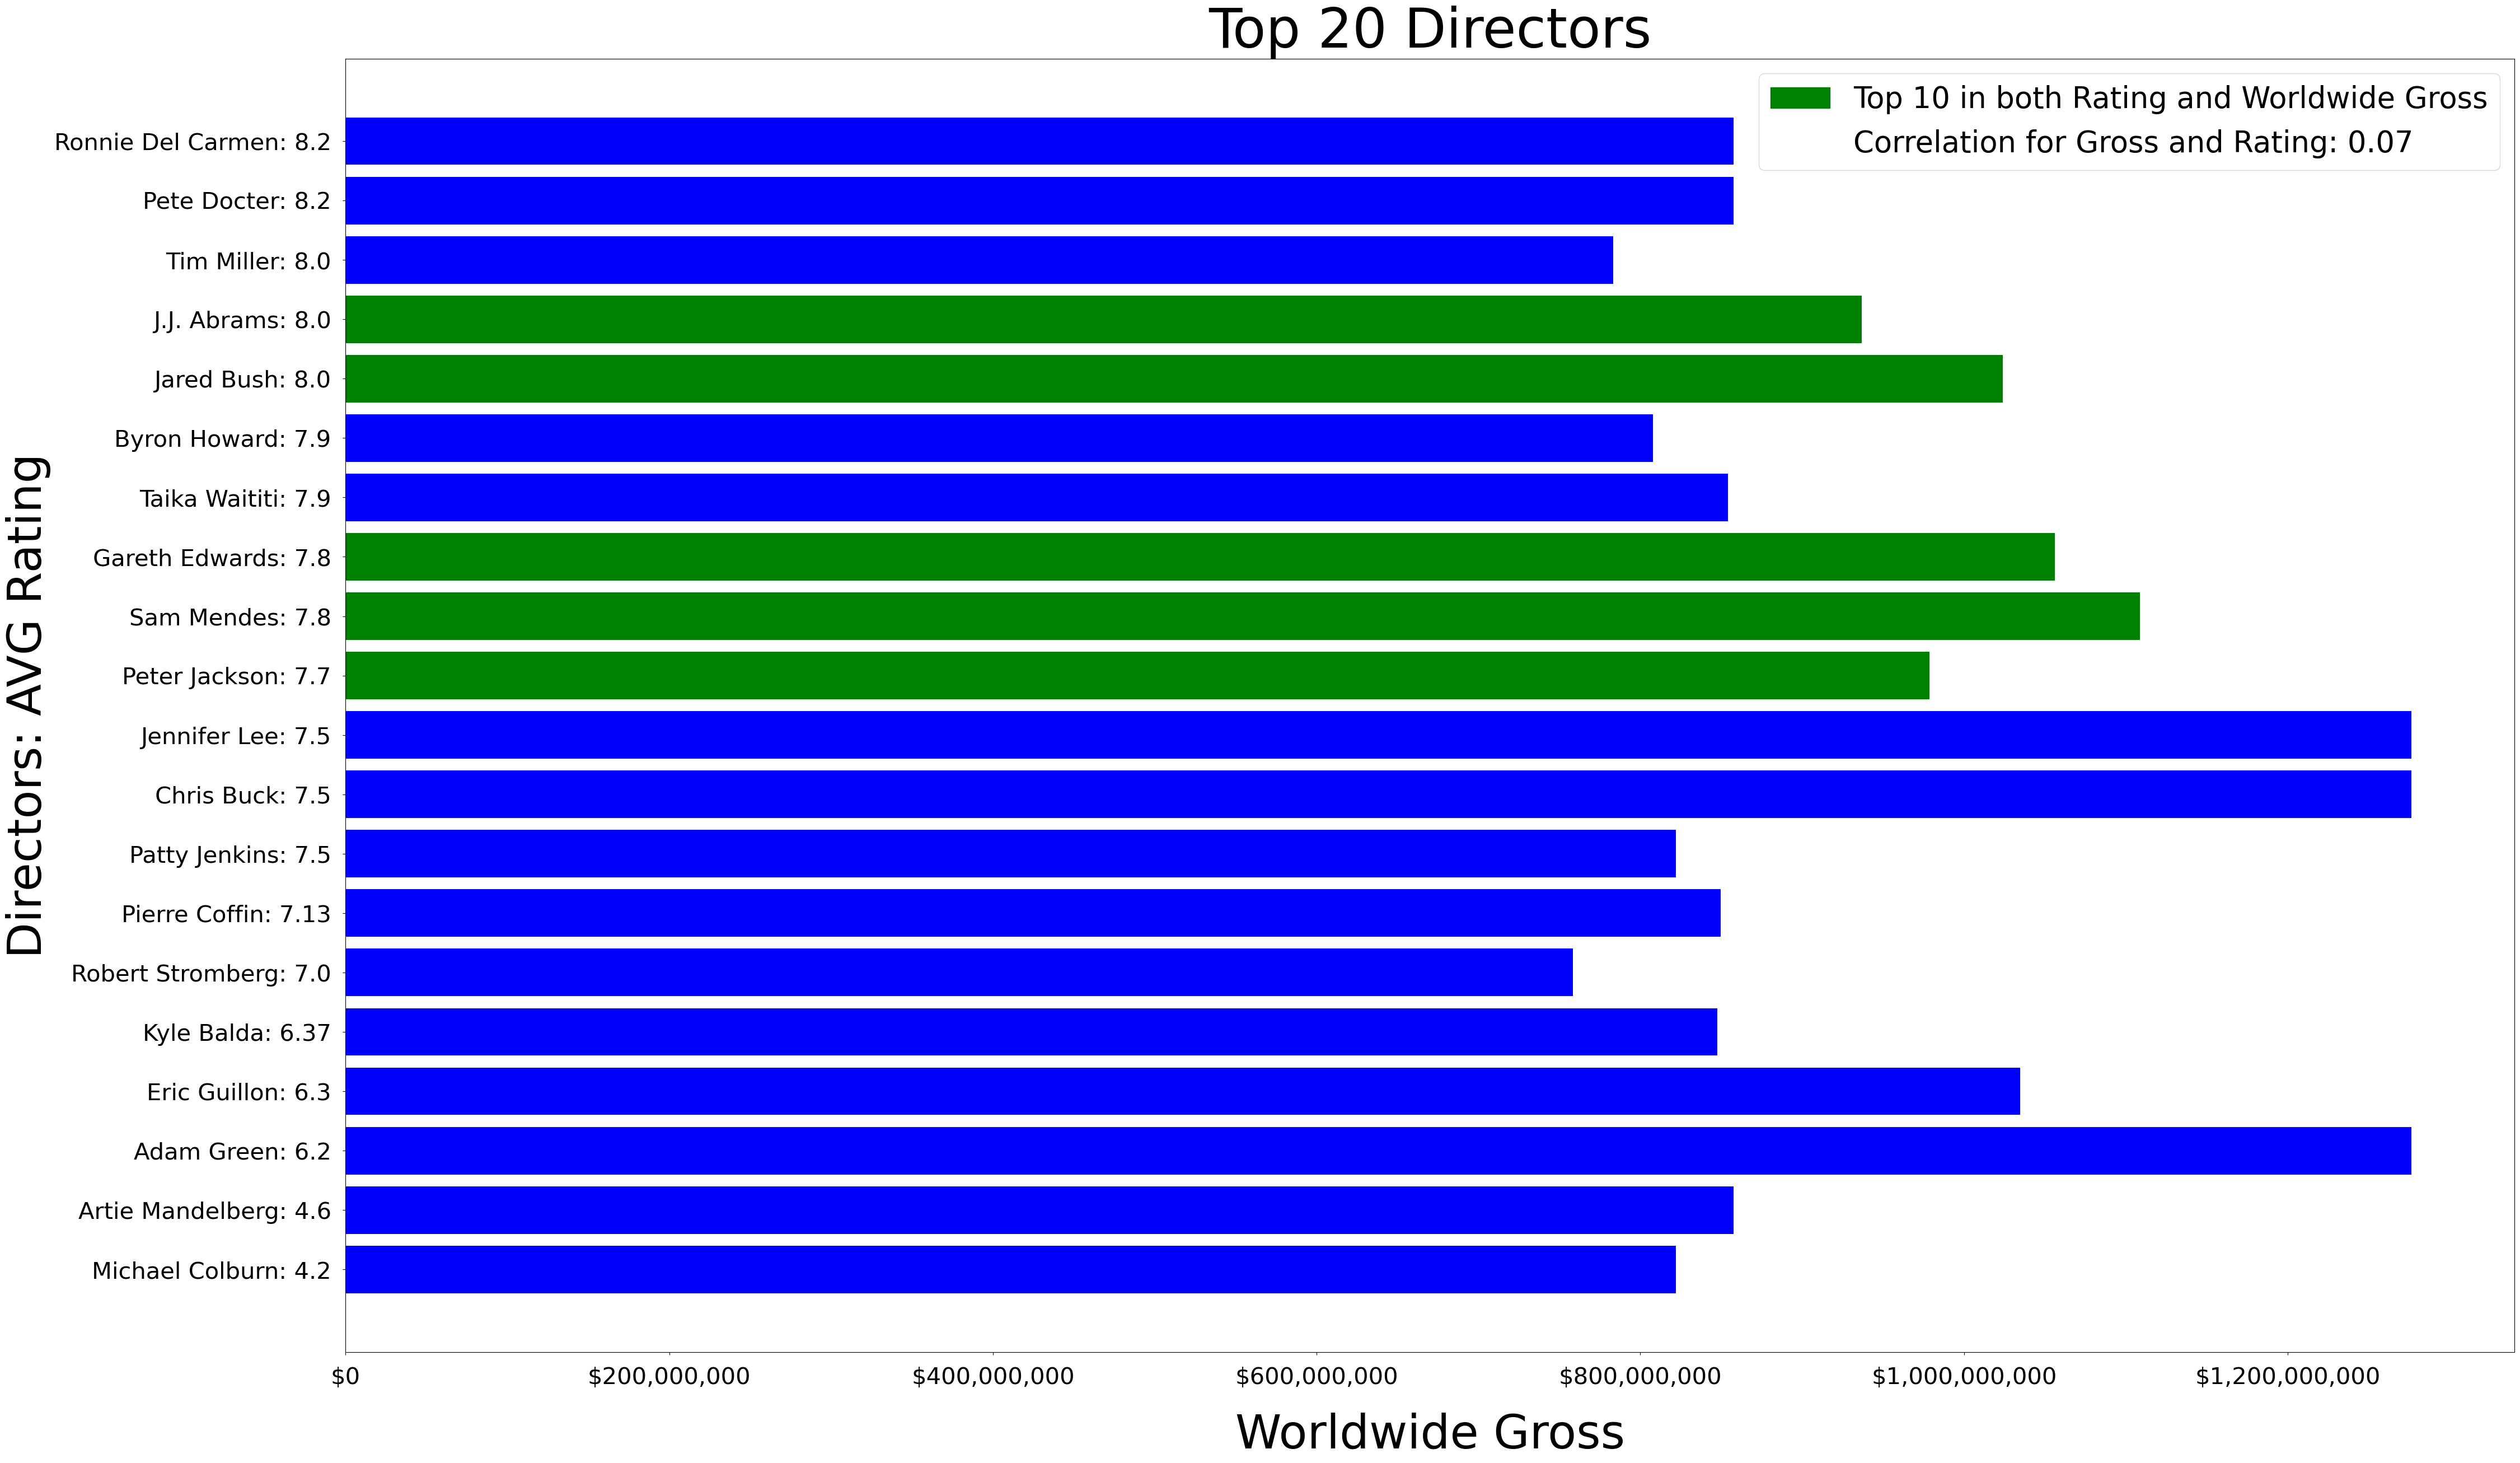

In [96]:
fig, ax = plt.subplots(figsize=(50,30))

# create list of bar color codes
bin_colors = ['b' if x not in top_directors else 'g' for x in top20_dir_by_rating.index]

# Bar chart
ax.barh(names_with_rating, gross, color=bin_colors)
ax.set_title('Top 20 Directors', size=70)

# Y-axis
ax.set_ylabel('Directors: AVG Rating', size=60)
ax.set_yticks(list(range(0,20)))
ax.set_yticklabels(names_with_rating, size=30)

# X-axis
ax.set_xlabel('Worldwide Gross', size=60)
ax.xaxis.labelpad = 30
x_ticks = [0,200000000, 400000000, 600000000, 800000000, 1000000000, 1200000000]
x_lables = ['$0', '$200,000,000', '$400,000,000', '$600,000,000', \
            '$800,000,000', '$1,000,000,000', '$1,200,000,000']
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_lables, size=30)
ax.tick_params(axis='both', which='major', pad=15)

# Legend
green_patch = mpatches.Patch(color='green', label='Top 10 in both Rating and Worldwide Gross')
corr_patch = mpatches.Patch(color='None',label=f'Correlation for Gross and Rating: {corr}')
plt.legend(handles=[green_patch, corr_patch], prop={'size': 38}, loc='upper right');
plt.savefig('top_directors.png')